# Analyzing NYC High School Data
This project is about ranking New York City High Schools by their SAT average score and analyzing which variables can contribute to some schools doing better than others. Some preprocessing was done to clean the data and making it easier to manipulate. Six datasets were joined together to handle all relevant variables. The datasets used were:

- `ap_2010.csv`: The Advanced Placement exam results for each high school.
- `class_size.csv`: The class size for each school.
- `demographics.csv`: The different demographic groups attending each school.
- `graduation.csv`: Percentage of students graduating from each school.
- `hs_directory.csv`: School attendance.
- `sat_results.csv`: SAT scores for each high school in New York City.

Additionally, two survey datasets, `survey_all.txt` and `survey_d75.txt` were used to assemble the school evaluations done by teachers, parents and students. 

The following steps in section 1 aim to join all this information together until we can reach the step were we can start making correlations in section 2.

## Section 1. Organizing all the data
### Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


### Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

## Section 2. Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

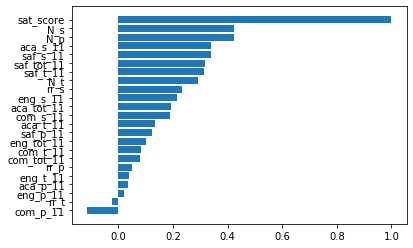

In [12]:
%matplotlib inline
#Create mask with all fields and add the 'sat_score' label
survey_corr_mask = survey_fields + ['sat_score']
survey_corr = combined[survey_corr_mask].corr()

#Find the 'y' and the 'width' of horizontal bar plot
survey_corr_y = numpy.arange(len(survey_corr['sat_score'].index))
survey_corr_w = survey_corr['sat_score'].sort_values().values

plt.barh(survey_corr_y,survey_corr_w)
plt.yticks(survey_corr_y,survey_corr['sat_score'].sort_values().index)
plt.show()

The horizontal bar plot with sorted values allows us to see the positive correlations and the negative  in an intuitive way. 'sat_score' correlates with itself so it shows a perfect positive value of 1. 'N_s' (Number of student respondents) and 'N_p' (Number of parent respondents) have the highest positive correlation. 'aca_s_11' (academic expectations based on student responses) has the next high correlation. This may indicate that a school who has high academic expectations from students tends to do better in the SATs.  'rr_t' (teacher response rate) and 'rr_s' (student response rate) show a negative correlation.

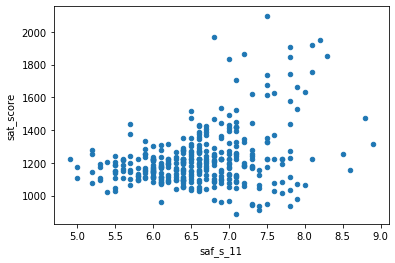

In [13]:
combined.plot.scatter('saf_s_11','sat_score')
plt.show()

The correlation between 'saf_s_11' (safety and respect student score) and the SAT scores shows that there could be a line going upward from left to right, indicating that when the sefety score rises, the SAT score also rises (positive correlation)

C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


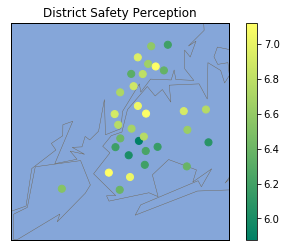

In [14]:
districts_safety = combined.groupby("school_dist").agg(numpy.mean)

import os 
os.environ['PROJ_LIB'] = 'C:/Users/joman/Anaconda3/Lib/site-packages/mpl_toolkits/basemap'
from mpl_toolkits.basemap import Basemap

longitudes = districts_safety["lon"].tolist()
latitudes = districts_safety["lat"].tolist()

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c=districts_safety["saf_s_11"],cmap="summer")
plt.title("District Safety Perception")
plt.colorbar()
plt.show()

The places with a higher safety score are scattered around new york, but most seem to appear between Manhattan and Brooklyn. The lowest safety scores also appear in Brooklyn. Districts with a medium safety score appear in Staten Island and Queens.

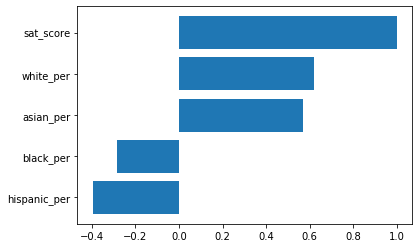

In [15]:
race_corr_mask = ['sat_score','white_per','asian_per',
                  'black_per','hispanic_per']
race_corr = combined[race_corr_mask].corr()

race_corr_y = numpy.arange(len(race_corr['sat_score'].index))
race_corr_w = race_corr['sat_score'].sort_values().values

plt.barh(race_corr_y,race_corr_w)
plt.yticks(race_corr_y,race_corr['sat_score'].sort_values().index)
plt.show()

The SAT scores correlated to the race columns indicate that hispanic and black students have a negative correlation, while asian and white students have a strong positive correlation. This means that being black or hispanic can translate lower SAT scores.

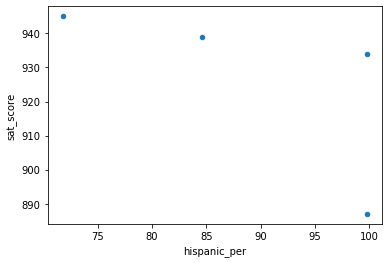

In [16]:
low_sat = combined[(combined['sat_score']<950) & (combined['hispanic_per']>30)]

low_sat.plot.scatter('hispanic_per','sat_score')
plt.show()

There are clearly 4 schools where the SATs are low (below 950) and the percentage of hispanic students is high (more than 30%). There is a trend showing that as the percentage of hispanic students increases, the SAT scores decrease, which indicates a negative correlation.

In [17]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

We can learn further about these schools in the [NYC Dept. of Education](https://www.schools.nyc.gov/) website. The 8 schools above have more than 95% of hispanic students and 0% other races. Most students are also English language learners.

In [18]:
combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

This set of schools with high SAT scores have mostly white and asian students. The English Language learners account for 0%.

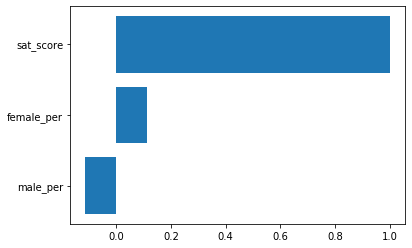

In [19]:
gender_corr_mask = ['sat_score','male_per','female_per']
gender_corr = combined[gender_corr_mask].corr()

gender_corr_y = numpy.arange(len(gender_corr['sat_score'].index))
gender_corr_w = gender_corr['sat_score'].sort_values().values

plt.barh(gender_corr_y,gender_corr_w)
plt.yticks(gender_corr_y,
           gender_corr['sat_score'].sort_values().index)
plt.show()
                             

Positive correlation for female students and negative for males. The correlations are not that strong regardless.

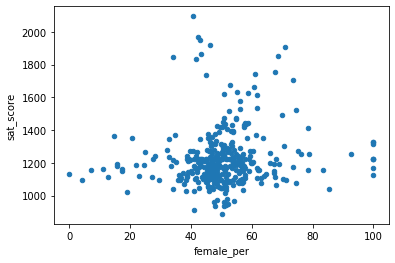

In [20]:
combined.plot.scatter('female_per','sat_score')
plt.show()

This plot shows that most schools with high female percentage do very well on SAT scores. The trend tends to go up as more female students seem to represent higher scores. Schools with the best scores seem to have around 50% female students.

In [21]:
combined[(combined['female_per']>60) & (combined['sat_score']>1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of these 5 schools have a mayority of white students. Some of them rated low on trust according to the NYC Dept. of Education website.

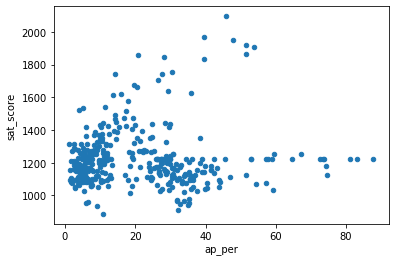

In [22]:
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment'])*100

combined.plot.scatter('ap_per','sat_score')
plt.show()

As more students take AP tests, there's an increase in SAT scores. Yet, some shools with high AP test takers (above 60%) don't seem to have high scores.

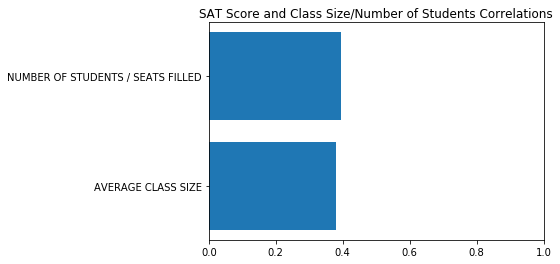

Correlation of average class size is  0.3810143308095523 
Correlation of number of students is 0.39462598144447314


In [23]:
class_size_corr = combined[['sat_score','AVERAGE CLASS SIZE','NUMBER OF STUDENTS / SEATS FILLED']].corr()

class_size_corr_y = numpy.arange(len(class_size_corr['sat_score'].index))
class_size_corr_w = class_size_corr['sat_score'].sort_values().values

plt.barh(class_size_corr_y[:2], class_size_corr_w[:2]) #Index list so that sat_score wont appear with correlation 1
plt.yticks(class_size_corr_y[:2],class_size_corr['sat_score'].sort_values().index[:2])
plt.xlim(0,1)
plt.title("SAT Score and Class Size/Number of Students Correlations")
plt.show()
print("Correlation of average class size is ",class_size_corr_w[0],"\nCorrelation of number of students is",
      class_size_corr_w[1])

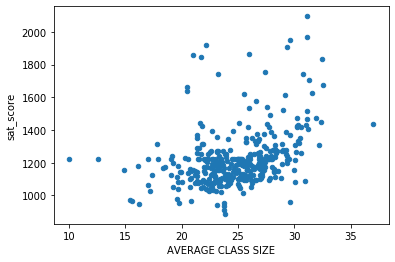

In [24]:
combined.plot.scatter('AVERAGE CLASS SIZE','sat_score')
plt.show()

We can see here that, as the average class size increases, the SAT scores increase. The correlation coefficient is 0.38, which is pretty moderate. Correlations above 0.4 are usually strong.

### Neighborhoods with the Best Schools

C:\Users\joman\Anaconda3\lib\site-packages\pandas\core\generic.py:5079: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\Users\joman\Anaconda3\lib\site-packages\pandas\core\generic.py:5080: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
C:\Users\joman\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


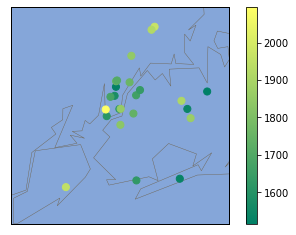

In [25]:
#Get the schools with score higher than 1500
best_schools = combined[combined['sat_score']>1500]
best_schools.is_copy = None #Use the is_copy property and set it to None to avoid a SettingWithCopyWarning

#Get the longitudes and latitudes as list
best_schools_lon =best_schools['lon'].tolist()
best_schools_lat =best_schools['lat'].tolist()

m2 = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m2.drawmapboundary(fill_color='#85A6D9')
m2.drawcoastlines(color='#6D5F47', linewidth=.4)
m2.drawrivers(color='#6D5F47', linewidth=.4)

m2.scatter(best_schools_lon,best_schools_lat,s=50,zorder=2,latlon=True,c=best_schools['sat_score'],cmap="summer")
plt.colorbar()
plt.show()

The best schools seem to appear at the center of the map, but we cannot say to which neighborhoods they belong. For that we'll use the coordinates that we already have and use a Python georeferencer like geopy to relate those values to a neighborhood from a list of NYC neighborhoods found in a web source.

In [26]:
#For geopy to work, we need latitude and longitude coordinates in string form
#So a new column will be created joinig the string version of 'lat' and 'lon'
best_schools["coords"] = best_schools.loc[:,"lat"].astype(str)+','+best_schools.loc[:,"lon"].astype(str)

#Use the georeferencer and create an object
from geopy.geocoders import Nominatim

#Override the default user_agent parameter with a madeup one to prevent deprecation warning
geolocator = Nominatim(user_agent='myapp/1',timeout = 7) #Increase timeout to avoid timeout error
#If timeout parameter doesn't help, use the RateLimiter
#This will allow multiple requests in case of timeouts
from geopy.extra.rate_limiter import RateLimiter 
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1) #Create the object

location_tuples = best_schools['coords'].apply(geocode) #Create a series with the applied function on 'coords'
location = geolocator.reverse("40.761432699000466,-73.98802369799967")#Create an example location to see if it works
location

Location(322, West 48th Street, Hell's Kitchen, Manhattan Community Board 4, Manhattan, New York County, New York, 10036, United States of America, (40.761279900000005, -73.98818145, 0.0))

We see we get a result with a complete location of a school, including the neighborhood (in this case the neighborhood is Hell's Kitchen). Now let's scale this to use it on all the schools.

In [27]:
#Create a new series that will show a cleaned version of the above results
#The results don't locate the neighborhood name in the same position, 
#by trial and error the neighborhood name was located in between the 2nd and 4th position, hence slice [1:5]
inter_neighborhd = location_tuples.apply(lambda x: x[0].split(', ')[1:5])
inter_neighborhd.head()

4     [Columbia Street, Lower East Side, Manhattan C...
5     [525, East Houston Street, Lower East Side, Ma...
22    [West 48th Street, Hell's Kitchen, Manhattan C...
23          [55, West 25th Street, Penn South, Chelsea]
24    [8th Avenue, Chelsea, Manhattan Community Boar...
Name: coords, dtype: object

In [28]:
#Get list of NY neighborhoods by scrapping the Wikipedia page containing a table of all neighborhoods
from urllib.request import urlopen
from bs4 import BeautifulSoup

url_NYnh = "https://en.wikipedia.org/wiki/Neighborhoods_in_New_York_City" #page url

html_NYnh = urlopen(url_NYnh)

NYnh = BeautifulSoup(html_NYnh, 'lxml')

def GetandCleanRows(soup_object):
    '''Utility function to get rows from a table in the website'''

    rows = soup_object.find_all('tr') #Get all rows in table
    row_list = []
    for row in rows: 
        str_cells = str(row.find_all('td')) #Convert each row into a string
        cleantext = BeautifulSoup(str_cells, "lxml").get_text() #Get just the text and remove all html syntax
        row_list.append(cleantext)
    return row_list

NYnh_list = GetandCleanRows(NYnh)
#Create a pandas dataframe, only rows 1 to 60 have relevant info
NY_neighborhoods_df = pd.DataFrame(NYnh_list[1:60]) 

import re
def getNY_Neighborhoods(s):
    '''Function to apply to dataframe, to get just the neighborhood name from string'''
    split = re.split(', |\n]',s)
    return split[4:-1]

#Create new series with results from the getNeighborhood() function
NY_neighborhoods_series = NY_neighborhoods_df[0].apply(getNY_Neighborhoods) #Apply to column 0
#Create a unique list of neighborhoods by joining all separate lists
NY_neighborhoods = []
for n in NY_neighborhoods_series:
    NY_neighborhoods += n

NY_neighborhoods[:5]

['Melrose', 'Mott Haven', 'Port Morris', 'Hunts Point', 'Longwood']

In [29]:
#create the function to select the neighborhood from the list of neighborhood
def getSchoolNeighborhood(s):
    '''Function to get the neighborhood of the school by
    matching the contents of inter_neighborhd with the list of all neighborhoods
    s: a list of 4 items where one of the items is the neighborhood name'''
    for i in s:
        if i in NY_neighborhoods:
            return i
    else:
        return s

best_schools['Neighborhood'] = inter_neighborhd.apply(getSchoolNeighborhood)
best_schools['Neighborhood'].head()

4     Lower East Side
5     Lower East Side
22     Hell's Kitchen
23            Chelsea
24            Chelsea
Name: Neighborhood, dtype: object

Now we can get a list of the neighborhoods with the best schools according to SAT score averages. As shown in the map, most of this neighborhoods are in Manhattan.

In [30]:
#Sort the dataframe according to SAT average score in descending order (High scores first)
#then get the unique values
top_neighborhoods = best_schools.sort_values(axis=0,by='sat_score',ascending=False)['Neighborhood'].unique()
for i in range(len(top_neighborhoods)):
    print(i+1,'-',top_neighborhoods[i])

1 - Battery Park City
2 - Bedford Park
3 - Oakwood
4 - Kingsbridge Heights
5 - Pomonok
6 - Jamaica
7 - Lower East Side
8 - Hamilton Heights
9 - Fort Greene
10 - Upper East Side
11 - Lincoln Square
12 - Williamsburg Houses
13 - Chelsea
14 - Sunnyside
15 - Sunnyside Gardens
16 - Sheepshead Bay
17 - Financial District
18 - Utopia
19 - Seaside
20 - Hell's Kitchen
21 - Oakland Gardens


## Investigating the differences between parent, teacher, and student responses to surveys.

In [31]:
survey_responses = combined[survey_fields]
survey_cols = survey_responses.columns #Get the names of the columns
survey_cols

Index(['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11',
       'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11',
       'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11',
       'com_tot_11', 'eng_tot_11', 'aca_tot_11'],
      dtype='object')

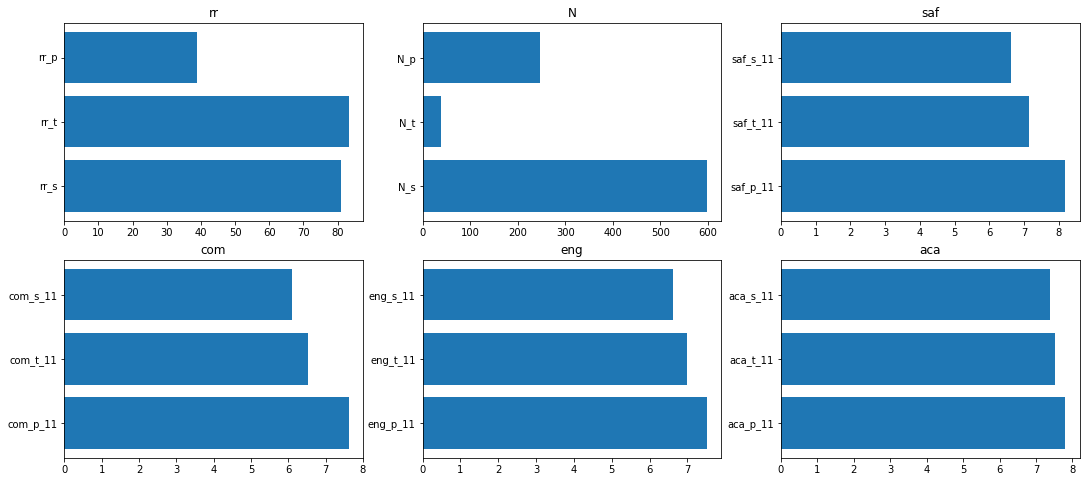

In [32]:
#Use regex to filter by survey and create dictionary
surv_patterns = {'rr_pattern' : r"rr_",
                 'N_pattern' : r"N_",
                 'saf_pattern':r"saf_(?!tot)", #Get all surveys starting with 'saf_' but negative lookahead of 'tot'
                 'com_pattern':r"com_(?!tot)",
                 'eng_pattern':r"eng_(?!tot)",
                 'aca_pattern':r"aca_(?!tot)"}

#Create subplots, 2 rows, 3 columns 
fig, axes = plt.subplots(2, 3,sharex=False,figsize=(12,8))#dont share x-axis
plt.subplots_adjust(right=1.3) #Modify the margins of the subplots so they don't overlap

#import itertools product to create the row,column combinations for the subplots
from itertools import product  
row_column = list(product([0,1,2],repeat=2))
position = 0

for i in surv_patterns:
    survey_filter = survey_cols.str.match(surv_patterns[i]) #Use match to match the patterns created in dictionary
    f = survey_responses[survey_cols[survey_filter]].mean() #Get the means of each column by respondent
    axes[row_column[position][0],row_column[position][1]].barh(f.index,f.values)
    axes[row_column[position][0],row_column[position][1]].set_title(i[:-8]) #Set the titles same as dict keys
    position += 1


Looking at the plots, we can see differences among the responses given depending if the respondent was a parent, student or teacher. In the first plot, for the survey 'rr' (Response Rate) we see the average response rate for the parents was half lower than that of teachers and students. The 'N' (Number of Respondents) shows that the average number of respondent was higher for students and parents, but no for teachers. The next plot, 'saf'(Safety and Respect Score), shows that the average score given by parents is higher than the one given by teachers or students. In the next 3 surveys (Communication, Engagement and Academic Expectation) the average scores given rank similar among the 3 types of respondents, with students always giving a lower average score and parents giving a higher one.